# PT-BR Financial News Classification

In [ ]:
'''
Plan: Add column for vector label (+1 good for Real, -1 bad for real, 0 meh)
1) when we need the dates we will have them
2) we will also have info in this prospective second column on whether the currency went up or down for each day in the file
3) we can automate this possibly with yahoo finance
we refers to me

issue: technically the labels in some code further below are in a dictionary so i'll have to figure that out
'''

import re
import pandas as pd

def extract_dates_from_file(file_path):
    date_pattern = r'\d{2}/\d{2}/\d{2}'
    dates = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        matches = re.findall(date_pattern, content)
        dates.extend(matches)
    
    dates_df = pd.DataFrame(dates, columns=['Date'])
    return dates_df

file_path = 'Clean_BDM_News_Corpus.txt'
dates_df = extract_dates_from_file(file_path)
display(dates_df)

,Date
0,09/01/24
1,10/01/24
2,11/01/24
3,12/01/24
4,15/01/24
5,16/01/24
6,19/01/24
7,22/01/24
8,23/01/24
9,24/01/24


In [ ]:
import pandas as pd
import re
from datetime import datetime

# this is where we look at the file and make it into a list
def parse_articles_to_df(file_path):
    dates = []  # this is where we keep the dates
    articles = []  # this is where we keep the articles
    
    with open(file_path, "r", encoding="utf-8") as file:
        current_date = None  # this is where we keep the date we are looking at right now
        current_articles = []  # this is where we keep the article for the current date
        
        for line in file:
            line = line.strip()  # take away spaces from the start and end
            if line:  # if the line is not empty
                if line[2] == "/":  # if the line looks like a date (dd/mm/yy)
                    # we had a date before, so let's save it with its articles
                    if current_date:
                        for article in current_articles:
                            dates.append(current_date)  # add the current date
                            articles.append(article)  # add the article for that date
                    # just use the date as is, don't change it
                    current_date = line  # keep the new date
                    current_articles = []  # start fresh for the new date
                else:
                    # this is the article, we keep adding it to the list
                    current_articles.append(line) 
        
        if current_date:  # when we are done looking at the file
            for article in current_articles:  # for all the articles we saved
                dates.append(current_date)  # add the date again
                articles.append(article)  # add the article again
    
    df = pd.DataFrame({'date': dates, 'article': articles})  # make a table with the dates and articles
    return df  # give back the table

file_path = "Clean_BDM_News_Corpus.txt"  # where the file is
df_articles = parse_articles_to_df(file_path)  # call the function to make the table

# show the table to see it
display(df_articles)

,date,article
0,09/01/24,"O petróleo testava reação moderada (+0,50%) no..."
1,09/01/24,Circularam comentários de que a reunião de Pac...
2,09/01/24,"De qualquer modo, seis senadores estão com a p..."
3,09/01/24,"Nos EUA, sai a balança comercial de novembro (..."
4,09/01/24,"O investidor cumpre a espera pela 5ªF, que pro..."
...,...,...
1097,31/01/24,Emissão é de apenas uma série e já tem valor d...
1098,31/01/24,"ROMI teve lucro líquido de R$ 51,340 milhões n..."
1099,31/01/24,ENEVA. Citi manteve recomendação de compra par...
1100,31/01/24,OI. Nova versão do plano de recuperação judici...


In [ ]:
import spacy

# spacy PT model
nlp = spacy.load('pt_core_news_sm')

#preprocessing
def preprocess_text_spacy(text):
    doc = nlp(text)
    
    # lemmatization and stopwords removal
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    
    #tokens back to 1 string
    return ' '.join(tokens)

# preprocess ALL articles in df (the file)
df_articles['processed_article'] = df_articles['article'].apply(preprocess_text_spacy)

# Display the processed articles
display(df_articles[['date', 'processed_article']].head())

,date,processed_article
0,09/01/24,petróleo testar reação moderar pregão asiático...
1,09/01/24,circularam comentário reunião Pacheco líder se...
2,09/01/24,modo senador presença confirmar Único indicado...
3,09/01/24,EUA sair balança comercial novembro Fed boy Mi...
4,09/01/24,investidor cumprir espera prometer emoção CPI ...


In [ ]:
#Attempt 1 

from gensim.models import Word2Vec

tokenized_articles = df_articles['processed_article'].apply(lambda x: x.split()).tolist()

model = Word2Vec(sentences=tokenized_articles, 
                 vector_size=100,   # dimensionality of the word embeddings
                 window=5,          # context window size
                 min_count=5,       # minimum frequency of words to consider
                 workers=4,         # CPUs for training
                 sg=0)              # Use CBOW (0) or Skip-Gram (1)

model.save("word2vec_brl_model.model")

#read about word embeddings
#read about the word2vec algorithm
#use pre-existing word2vec

In [ ]:
#Attempt 2

from gensim.models import Word2Vec

# Tokenize articles
tokenized_articles = df_articles['processed_article'].apply(lambda x: x.split()).tolist()

# Improved Word2Vec model
model = Word2Vec(sentences=tokenized_articles, 
                 vector_size=200,   # Increased dimensionality
                 window=10,         # Larger context window
                 min_count=3,       # Lower threshold for words
                 workers=4,         # CPUs for training
                 sg=1)              # Use Skip-Gram

# Save the improved model
model.save("word2vec_brl_model_improved.model")


In [ ]:
import numpy as np

# generating article vectors based on average
def get_article_vector(article, model):
    tokens = article.split()  # Tokenize the article
    word_vectors = []
    
    for token in tokens:
        if token in model.wv:  # if word in Word2Vec model
            word_vectors.append(model.wv[token])
    
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# create article vectors and add them to the df
df_articles['article_vector'] = df_articles['processed_article'].apply(lambda x: get_article_vector(x, model))

article_vectors = df_articles[['date', 'article_vector']]

#if you wanna CSV for better readability
article_vectors.to_csv('article_vectors.csv', index=False)

display(article_vectors.head())

,date,article_vector
0,09/01/24,"[-0.03724732, -0.007848836, -0.0059654154, 0.1..."
1,09/01/24,"[-0.031171255, -0.006783408, -0.006185807, 0.1..."
2,09/01/24,"[-0.032220792, -0.00648562, -0.004106843, 0.10..."
3,09/01/24,"[-0.038137928, -0.0059848726, -0.0012495067, 0..."
4,09/01/24,"[-0.048136882, -0.007164541, -0.0032707923, 0...."


In [ ]:
'''
0 for neutral
+1 for up
-1 for down
'''
     
labels = {
    '09/01/24': 1, # 0.8% change
    '10/01/24': 0, # 0.2% change
    '11/01/24': -1, # 0.6% change
    '12/01/24': -1, 
    '15/01/24': 1,
    '16/01/24': 1,
    '19/01/24': 0,
    '22/01/24': 1,
    '23/01/24': -1,
    '24/01/24': -1,
    '25/01/24': -1,
    '26/01/24': -1,
    '29/01/24': 1,
    '30/01/24': 1,
    '31/01/24': 1
}

# add lablels to df
df_articles['label'] = df_articles['date'].map(labels)
df_articles.to_csv('article_vectors_with_labels.csv', index=False) 

#### Multinomial Logistic Regression Model with Custom Word2Vec Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Assuming df_articles already has processed_article and labels

# Step 1: Prepare the data (X = article vectors, y = labels)
X = np.vstack(df_articles['article_vector'].values)  # Stack article vectors into a 2D array
y = df_articles['label'].values  # Labels corresponding to the article

# Step 2: Train-test split (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=42)

# Step 3: Train a multinomial Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced', C=1.0, penalty='l2') 
clf.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = clf.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Classification report (precision, recall, f1-score)
classification_rep = classification_report(y_test, y_pred, output_dict=True)  # Get classification report as a dictionary

# Confusion matrix (Actual vs Predicted classes)
conf_matrix = confusion_matrix(y_test, y_pred)

# Convert the evaluation results into clean dataframes for display
classification_rep_df = pd.DataFrame(classification_rep).transpose()  # Convert classification report to dataframe
conf_matrix_df = pd.DataFrame(conf_matrix, 
                               index=["Down", "Neutral", "Up"], 
                               columns=["Down", "Neutral", "Up"])  # Confusion matrix as dataframe

# Step 6: Display the results
print("Accuracy:", accuracy)
display(classification_rep_df)

Accuracy: 0.30612244897959184


,precision,recall,f1-score,support
-1,0.371014,0.351648,0.361072,364.000000
0,0.108280,0.326923,0.162679,104.000000
1,0.484305,0.260870,0.339089,414.000000
accuracy,0.306122,0.306122,0.306122,0.306122
macro avg,0.321200,0.313147,0.287614,882.000000
weighted avg,0.393212,0.306122,0.327360,882.000000


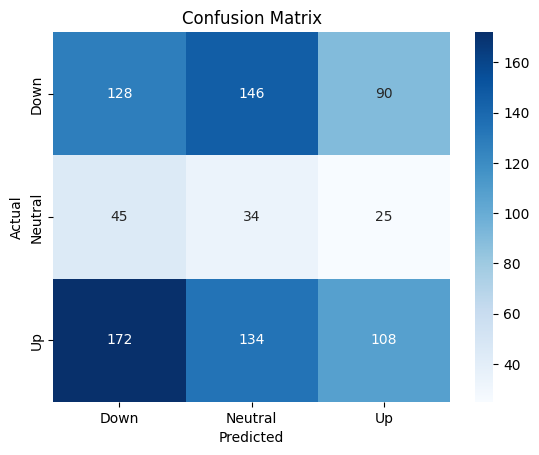

In [ ]:
# Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_test is actual labels and y_pred is predicted labels
cm = confusion_matrix(y_test, y_pred)

# heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Neutral', 'Up'], yticklabels=['Down', 'Neutral', 'Up'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# display plot
plt.show()

#### Multinomial Logistic Regression Model with Custom Word2Vec Model - Attempt 2